## Code and Documentation to Decode Pop-up Float (PuF) Transmitted/Recorded Data
### A Close Look at Bottom Data (BOTDAT.TXT)

## Software Requirements

Developed/tested for:
- python >=3.6 

requires:
- pyyaml >= 3.13 
- pandas >= 0.23.4
- numpy >= 1.15.4
- matplotlib >= 3.0.2
- jupyterlab >= 1.0.0 

In [1]:
import numpy as np
import pandas as pd
import yaml
import collections
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
#from matplotlib.ticker import NullFormatter  # useful for `logit` scale

import datetime
from netCDF4 import num2date, date2num


## Data Structure

Data downloaded from PuFs directly, generate 8 binary files.  A complete description of these files can be found at **[link]**.  Relevant pieces will be included in the notebook.

Filenames:
- BOTDAT.TXT
- FILEPOS.TXT
- ICEDAT.TXT
- JPGxxxxx.JPG
- PRODAT.TXT
- SSTDAT.TXT
- SUMMARY.TXT

In [2]:
# year deployed - year of data - imei number - site: SBD Active/Inactive 

# 2018 - 300434063921240 - C2: Inactive
# 2018 - 300434063823800 - C10/C11: Inactive
# 2018 - 300434063928220 - C12: Inactive
# 2018 - 300434063925210 - M5: Inactive

# 2019 - 300434063470010 - S.W. of M5: Inactive
# 2019 - 300434063477010 - N.W. of M5: Inactive
# 2019 - 300434063861360 - N.E. of Saint Lawrence: Inactive

#INPUT (imei) imei serial number, and (imei_sn) last 4 digits of imei serial number, and year deployed
imei = '300434063470010' 
year = '2019'

In [3]:
instfile_dic = {'pro_file': '..//results/'+ year +'/'+ imei +'/PRODAT.TXT',
                'ice_file': '..//results/'+ year +'/'+ imei +'/ICEDAT.TXT',
                'bot_file': '..//results/'+ year +'/'+ imei +'/BOTDAT.TXT',
                'sst_file': '..//results/'+ year +'/'+ imei +'/SSTDAT.TXT'}
instconfig = '..//yaml'+'/'+ imei+'.yaml'

For each data file, we are going to read in the entire file and convert the binary to hex.  There are multiple line, lengths we are going to have to address but the start of each record is denoted by 'FFFF'.  We can split the filestring on this parameter but we need to be aware of 'FFFFF' or 'FFFFFF' posibilities

***Basic Approach***

The two modules below will allow for a simple readin of the file for very simple analysis and debugging... the code of consequence that involves conversion of measurements from engineering units to science units as all defined in the PuFs CLASS in the next section

In [4]:
def HexView(file):
    with open(file, 'rb') as in_file:
        while True:
            hexdata = in_file.read().hex().upper()     # Read the shortest possible line
            if len(hexdata) == 0:                      # breaks loop once no more binary data is read
                break
            
            return(hexdata.upper())
        
def HexSplit(hexstr):
    if hexstr.find('FFFFF') == -1:
        print("No FFFFF, proceed to split on FFFF")
        sample_raw = hexstr.split('FFFF')[1:]
    else:
        print('FFFFF found')
        #this puts in the proper line endings but removes a variable 
        #   F from the end of each string.  Add the F string back
        sample_raw = []
        for substr in hexstr.split('FFFFF')[1:]: 
            sample_raw = sample_raw + (substr + 'F').split('FFFF')

        sample_raw[-1] = sample_raw[-1][:-1]
        
    return(sample_raw)

In [5]:
active_file = instfile_dic['bot_file']

hexstr = HexView(active_file)
sample_raw = HexSplit(hexstr)


FFFFF found


# Class description and routine code

## Decode sample data for bottom file type

### Bottom Data (BOTDAT.TXT)

This data has two record lengths.  17 and 19.  Since we've split on 'FFFF' and broken the record up into samples, the initial 2bytes are no longer in the record so the record lengths are now 15 and 17 (which is a string length of 30 and 34 characters)

***MSG Decode Key***
![BotDecodeMsg](decode_images/BotDat_msg_decode.png)

***Engineering to Science Conversions***
![BotDecodeMsg](decode_images/BotDat_msg_cal.png)


### Defining the PopUpfloat Class

import functions

preload matplotlib plot paramters

In [6]:
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

mpl.rcParams['contour.negative_linestyle'] = 'solid'


In [7]:
def signed_int(hexstr):
    '''function to convert hex string to signed int'''
    s_int = int(hexstr,16)
    if s_int >= 0x8000:
        s_int -= 0x10000  

    return(s_int)

class PuFs(object):
    """Class definitions to read and Process PopUp float Data Streams"""


    active_stream = 'bottom'
    def __init__(self, path):
        self.path = path
        self.instfile_dic = {'bottom': path + '/BOTDAT.TXT',
                             'ice': path + '/ICEDAT.TXT',
                             'profile': path + '/PRODAT.TXT',
                             'sst': path + '/SSTDAT.TXT'}
    
    def LoadCoefs(self, config_file='default.yaml'):
        ''' Load yaml formated config file '''
        self.config = yaml.safe_load(open(config_file))

    
    def HexView(self, active_stream='', verbose=True):
        '''
        input: reference to proper filepointer, options are keys 
            to the self.instfile_dic dictionary
        '''
        if active_stream:
            self.active_stream = active_stream
            
        file = self.instfile_dic[self.active_stream]
        with open(file, 'rb') as in_file:
            while True:
                hexdata = in_file.read().hex().upper()     
                if len(hexdata) == 0:                      
                # breaks loop once no more binary data is read
                    break
                self.hexstr = hexdata.upper()
                
                if verbose:
                    return(hexdata.upper())

    def HexSplit(self, verbose=True):
        '''
        input: results of HexView (inherits output)
        '''
        if self.hexstr.find('FFFFF') == -1:
            print("No FFFFF, proceed to split on FFFF")
            #because in this case the first index is empty
            sample_raw = self.hexstr.split('FFFF')[1:] 
        else:
            print('FFFFF found')
            #this puts in the proper line endings but removes a variable 
            #   F from the end of each string.  Add the F string back
            sample_raw = []
            for substr in self.hexstr.split('FFFFF'): 
                sample_raw = sample_raw + (substr + 'F').split('FFFF')

            sample_raw[-1] = sample_raw[-1][:-1]
        
        self.sample_raw = sample_raw
        
        if verbose:
            return(sample_raw)
    
    def Bottom(self, asPandas=False):
        ''' Bottom is equivalent to the TimeSeriesBase'''
        
        if self.active_stream != 'bottom':
            print("current active file is {} - can't output bottom data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    

    def Profile(self, asPandas=False):
        try:
            self.sample_raw
        except:
            print("Run PuFs.HexView and PuFs.HexSplit First")
            return

        if self.active_stream != 'profile':
            print("current active file is {} - can't output profile data".format(self.active_stream))
            return
                        
        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):
                        
            if len(sample) == 22: #2byte timeword
                
                # unlike sst, bottom, and ice - profiles don't need to be multiplied by a sample interval
                #seconds since 1970-01-01
                try:
                    time = int(sample[0:4],16)/100 + profile_starttime
                except:
                    time = int(sample[0:4],16)/100 + 0
                    
                pressure =  self.PressureConversion(int(sample[4:8],16)) 
                
                fr_temp_ADC = signed_int(sample[8:12])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])

                rawpvalue = signed_int(sample[12:16])                  
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])   

                rawfvalue = signed_int(sample[16:20])                   
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[20:22],16) #degrees
                
            elif len(sample) == 26: #4byte timeword, reserved for profile starttime
                
                #seconds since 1970-01-01
                profile_starttime = int(sample[0:8],16)
                
                time = profile_starttime
                
                pressure =  self.PressureConversion(int(sample[8:12],16))  
                
                fr_temp_ADC = signed_int(sample[12:16])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])
                
                rawpvalue = signed_int(sample[16:20])             
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[20:24])                
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[24:26],16) #degrees
            
            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'fr_temp':fr_temp,
                                'fr_temp_ADC':fr_temp_ADC,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}        
        
        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
        
    def Ice(self, asPandas=False):
        ''' Ice is equivalent to the TimeSeriesBase'''

        if self.active_stream != 'ice':
            print("current active file is {} - can't output ice data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()

        if asPandas:
            data = pd.DataFrame.from_dict(data,orient='index')
        return(data)
    
    def SST(self, asPandas=False):
        ''' SST is equivalent to the TimeSeriesBase + GPS information'''
        
        if self.active_stream != 'sst':
            print("current active file is {} - can't output sst data".format(self.active_stream))
            return

        data = self.TimeSeriesBase()


        for sample_num, sample in enumerate(self.sample_raw):

            if (len(sample) == 30) or (len(sample) == 66): #2byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 66:
                    print("analyze GPS")
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 32) or (len(sample) == 68): #2byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 68:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=2, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 34) or (len(sample) == 70): #4byte timeword, no TTS (w and w/o gps)
                TTS = np.nan
                if len(sample) == 70:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=4, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif (len(sample) == 36) or (len(sample) == 72): #4byte timeword, yes TTS (w and w/o gps)
                TTS = int(sample[30:32],16)
                if len(sample) == 72:
                    gps_data = self.GPSSeriesBase(sample_num, sample, offset=6, empty=False)
                else:
                    gps_data = self.GPSSeriesBase(sample_num, sample, empty=True)

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary

            try:
                data[sample_num].update({'TTS':TTS})        
                data[sample_num].update(gps_data[sample_num])
            except:
                pass

        if asPandas:
            return(pd.DataFrame.from_dict(data,orient='index'))
        else:
            return(data)


    ### The folowing BASE functions are for convenience for reading and coding.  All redundant
    # pattern reads are below.  The only challenge is that each BASE function reads the entire hex
    # string (non-issue for files of size we expect)
    def GPSSeriesBase(self,sample_num, sample, offset=0, empty=True):
        '''SST only, the last 18 bytes are the same format:
         GPSLat, GPSLon, GPSDate, GPSTime, TTF, Max_Tilt
         Regardless of whether TTS or longdates are used.  This subroutine returns the 
         GPS dictionary based on a byte offset given the record length

         Passing empty=True sends missing data back for GPS Data'''
        data=collections.OrderedDict()

        if not empty:
            GPSLat = int(sample[30+offset:38+offset],16)/1000000
            GPSLon = (int(sample[38+offset:46+offset],16)- 4294967295) / 1000000
            GPSDate = int(sample[46+offset:54+offset],16)
            GPSTime = int(sample[54+offset:62+offset],16)
            TTF = int(sample[62+offset:64+offset],16)
            Max_Tilt = int(sample[62+offset:66+offset],16)   

        else:
            GPSLat = GPSLon = GPSDate = GPSTime = TTF = Max_Tilt = np.nan 
            
        #save to dictionary
        data[sample_num] = {'GPSLat':GPSLat,
                            'GPSLon':GPSLon,
                            'GPSDate':GPSDate,
                            'GPSTime':GPSTime,
                            'TTF':TTF,
                            'Max_Tilt':Max_Tilt}  
            
        return(data)   

    def TimeSeriesBase(self):
        '''Bottom, Ice, and SST all have the same base transmission information,
            e.g. the first 17 bytes (short time stamp) / 19 bytes (long time stamp)
            are the same.  Each of the the appropriate modules will call this communal module
            first.

            Bottom and Ice don't report any additional information beyond the base info so 
            they are essential decorators/wrappers for this function

            Returns: Dictionary'''
        try:
            self.sample_raw
        except:
            print("Run PuFs.HexView and PuFs.HexSplit First")
            return

        data=collections.OrderedDict()

        for sample_num, sample in enumerate(self.sample_raw):
            
            #record length conditionals are due to number of varying outputs
            #SST dominates the number of options due to:
            # 2byte timeword, no TTS, no GPS (30)
            # 4byte timeword, yes TTS, yes GPS (72)
            #  and every permutation of the three functions
            if ((len(sample) == 30) or (len(sample) == 32) or 
                            (len(sample) == 60) or (len(sample) == 64) or (len(sample) == 66) or (len(sample) == 68)) : #2byte timeword
                
                #seconds since 1970-01-01
                if self.active_stream in ['sst']:
                    #the correction is available for any non-utc setup pc
                    time_base = date2num(datetime.datetime.strptime(IDNUMBER.config['Unit_Release_Time'],
                                        '%Y-%m-%d %H:%M:%S'),
                                                                    'seconds since 1970-1-1')
                else:
                    time_base = 0 

                time = int(sample[0:4],16) * self.config['sample_interval'][self.active_stream] + time_base
                
                pressure =  self.PressureConversion(int(sample[4:8],16))  
                
                fr_temp_ADC = signed_int(sample[8:12])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])

                sr_temp_ADC = signed_int(sample[12:16])
                sr_temp = self.TempConversion(engr_meas=sr_temp_ADC,
                                                  coefA=self.config['sr_temp_cal']['Acoef'], 
                                                  coefB=self.config['sr_temp_cal']['Bcoef'],
                                                  coefC=self.config['sr_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[16:20])               
                
                rawpvalue = signed_int(sample[20:24])               
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope']) 
                
                rawfvalue = signed_int(sample[24:28])                 
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  

                tilt = int(sample[28:30],16) #degrees
                
            elif ((len(sample) == 34) or (len(sample) == 36) or (len(sample) == 72)) : #4byte timeword
                
                #seconds since 1970-01-01
                time = int(sample[0:8],16)
                
                pressure =  self.PressureConversion(int(sample[8:12],16))   
                
                fr_temp_ADC = signed_int(sample[12:16])
                fr_temp = self.TempConversion(engr_meas=fr_temp_ADC,
                                                  coefA=self.config['fr_temp_cal']['Acoef'], 
                                                  coefB=self.config['fr_temp_cal']['Bcoef'],
                                                  coefC=self.config['fr_temp_cal']['Ccoef'])

                sr_temp_ADC = signed_int(sample[16:20])
                sr_temp = self.TempConversion(engr_meas=sr_temp_ADC,
                                                  coefA=self.config['sr_temp_cal']['Acoef'], 
                                                  coefB=self.config['sr_temp_cal']['Bcoef'],
                                                  coefC=self.config['sr_temp_cal']['Ccoef'])

                temp_ref = signed_int(sample[20:24])          
                
                rawpvalue = signed_int(sample[24:28])                 
                par = self.PARConversion(engr_meas=rawpvalue,
                                        coef_offset=self.config['par_cal']['offset'], 
                                        coef_slope=self.config['par_cal']['slope'])  

                rawfvalue = signed_int(sample[28:32])               
                fluor = self.FluorConversion(engr_meas=rawfvalue,
                                        coef_offset=self.config['fluor_cal']['offset'], 
                                        coef_slope=self.config['fluor_cal']['slope'])  
                
                tilt = int(sample[32:34],16) #degrees            

            elif len(sample) == 0:
                continue
            else:
                continue # skip lines with too many data points
            #save to dictionary
            data[sample_num] = {'time':time,
                                'pressure':pressure,
                                'fr_temp':fr_temp,
                                'fr_temp_ADC':fr_temp_ADC,
                                'sr_temp':sr_temp,
                                'sr_temp_ADC':sr_temp_ADC,
                                'temp_ref':temp_ref,
                                'par':par,
                                'fluor':fluor,
                                'tilt':tilt}  
        return(data)

    @staticmethod
    def PARConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate PAR from raw measurement
        
            (ADC_val - coef_offset) * coef_slope / 0.73

            output is PAR in umolm-2s-1
        '''
        return((engr_meas - coef_offset) * coef_slope / 0.73 )

    @staticmethod
    def FluorConversion(engr_meas,coef_offset, coef_slope):
        ''' Calculate Fluometer from raw measurement

            (ADC_val - coef_offset) * coef_slope
        
            output is concentration in ug/L
        '''
        return((engr_meas - coef_offset) * coef_slope) 

    @staticmethod
    def PressureConversion(engr_meas):
        ''' Calculate Pressure from raw measurement

            (ADC_val - 16384) * 10 / 32768
        
            output is Pressure in Bars
        '''
        return((engr_meas - 16384) * 10 / 32768)

    @staticmethod
    def TempConversion(engr_meas, coefA, coefB, coefC):
        ''' Calculate Temperature from raw measurement.

        1 / ( coefA + 
              coefB*np.log10(ADC_val) + 
              coefC*np.log10(ADC_val)^3 ) - 273.15

            output is Temperature in DegC
        '''
        temperature = 1 / ( coefA + 
                     coefB*np.log10(engr_meas) + 
                     coefC*np.log10(engr_meas)**3 ) - 273.15

        return(temperature)

## Sample Evaluation of routine

Imagine a float with ID number **xxxxx**.  Instantiate a PuFs class with the relative (or absolute) path to the location of the download/reconstructed data files

In [8]:
IDNUMBER = PuFs('..//results/' + year + '/' + imei)

Load the configuration file.  If not specified it will load a file named 'default.yaml' in the same path as the utility

In [9]:
IDNUMBER.LoadCoefs(config_file=instconfig)

Call the routine to read and convert the binary file to a hex string... the sample parameter is the name of the data type.

active_stream options are:
+ bottom
+ sst
+ profile
+ ice

passing 'verbose=True' returns the hex string

In [10]:
IDNUMBER.HexView(active_stream='bottom',verbose=False)

In [11]:
IDNUMBER.HexSplit(verbose=False)

FFFFF found


In [12]:
bottom_data = IDNUMBER.Bottom(asPandas=True)
print(bottom_data)

          time  pressure   fr_temp  fr_temp_ADC   sr_temp  sr_temp_ADC  \
1            0  6.149292  3.467390        23350  3.429345        23229   
2         3600  6.154785  3.495572        23317  3.458435        23196   
3         7200  6.164856  3.521228        23287  3.484042        23167   
4        10800  6.178284  3.522939        23285  3.486694        23164   
5        14400  6.207581  3.504975        23306  3.468144        23185   
...        ...       ...       ...          ...       ...          ...   
3874  13942800  6.139221 -1.790992        30428 -1.844920        30313   
3875  13946400  6.127930 -1.792293        30430 -1.845553        30314   
3876  13950000  6.127625 -1.793594        30432 -1.846819        30316   
3877  13953600  6.134644 -1.791643        30429 -1.844920        30313   
3878  13957200  6.150208 -1.790342        30427 -1.844288        30312   

      temp_ref  par  fluor  tilt  
1         8515  0.0      0     3  
2         8515  0.0      0     2  
3     

### Convert elapsed time to datetime

In [13]:
bottom_data['datetime'] = [num2date(x['time'],'seconds since '+ str(IDNUMBER.config['Unit_Start_Time']) ) for i,x in bottom_data.iterrows()]

#time functions are in netcdf4 library
#Bottom and Ice data start marking time from the "Unit_Start_Time" and "Unit_Release_Time" which should be incorporated into the config file

print(yaml.dump(IDNUMBER.config, default_flow_style=False))

#Trim out deck data using deploy date in config file for output csv files
#bottom_data = bottom_data.drop(bottom_data[bottom_data['datetime'] < (IDNUMBER.config['Unit_Deploy_Time']).index
#type('time')

Deploy_Depth: 62.5
Deploy_LatN: 60.6118
Deploy_LonW: -173.4542
Deployment_ID: 19BSITAE-TP0010
ENG_SN: '0214'
IMEI: 300434063470010
IMEI_SN: '0010'
Unit_Deploy_Time: '2019-09-24 16:30:00'
Unit_Release_Time: '2020-10-31 00:00:00'
Unit_Start_Time: '2019-10-01 00:00:00'
fluor_cal:
  offset: 0
  slope: 0
fr_temp_cal:
  Acoef: 0.002048
  Bcoef: 0.0002383
  Ccoef: 6.312e-06
par_cal:
  offset: 0
  slope: 0
sample_interval:
  bottom: 3600
  ice: 3600
  sst: 3600
sr_temp_cal:
  Acoef: 7.761e-05
  Bcoef: 0.0009076
  Ccoef: -5.102e-06



In [14]:
bottom_data

,time,pressure,fr_temp,fr_temp_ADC,sr_temp,sr_temp_ADC,temp_ref,par,fluor,tilt,datetime
1,0,6.149292,3.467390,23350,3.429345,23229,8515,0.0,0,3,2019-10-01 00:00:00
2,3600,6.154785,3.495572,23317,3.458435,23196,8515,0.0,0,2,2019-10-01 01:00:00
3,7200,6.164856,3.521228,23287,3.484042,23167,8515,0.0,0,2,2019-10-01 02:00:00
4,10800,6.178284,3.522939,23285,3.486694,23164,8515,0.0,0,1,2019-10-01 03:00:00
5,14400,6.207581,3.504975,23306,3.468144,23185,8515,0.0,0,0,2019-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
3874,13942800,6.139221,-1.790992,30428,-1.844920,30313,8514,0.0,0,0,2020-03-10 09:00:00
3875,13946400,6.127930,-1.792293,30430,-1.845553,30314,8514,0.0,0,3,2020-03-10 10:00:00
3876,13950000,6.127625,-1.793594,30432,-1.846819,30316,8514,0.0,0,0,2020-03-10 11:00:00
3877,13953600,6.134644,-1.791643,30429,-1.844920,30313,8514,0.0,0,1,2020-03-10 12:00:00


*Bottom Temp Detail*

TypeError: float() argument must be a string or a number, not 'cftime._cftime.DatetimeGregorian'

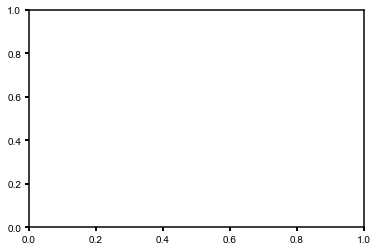

In [15]:
plt.plot(bottom_data.datetime,bottom_data.fr_temp, label='fast-response temperature', linewidth=1.5)
plt.plot(bottom_data.datetime,bottom_data.sr_temp, label='slow-response temperature', linewidth=1.5)
plt.ylabel('Temperature ($^\circ$C)', labelpad=12)
plt.xlabel('Date', labelpad=12)
plt.title('Bering Sea Bottom Temperature', pad=15)
plt.xticks(rotation=30)
plt.yticks(np.arange(-2, 6.5, 0.5))
plt.minorticks_on()
plt.tick_params(direction='out', top=True, labeltop=False, right=True, labelright=False)
plt.legend(loc='upper right')

plt.savefig( '..//results/'+ year + '/'+ imei + '/' + imei+'_bottom_data.png', dpi=800)

### Saving Data to be used in other software

simple as sending the pandas dataframe to csv

In [ ]:
#add id,lat,lon from config to datafiles
try:
    bottom_data['id'] = IDNUMBER.config['IMEI']
    bottom_data['dep_lat'] = IDNUMBER.config['Deploy_LatN']
    bottom_data['dep_lon'] = IDNUMBER.config['Deploy_LonW']
    bottom_data.to_csv( '..//results/'+imei + '/'+year + '/' + imei+'_bottom_data.csv')
except:
    print("No bottom data")  
